## Numerical Experiment 3: Classification with LDA

In [1]:
# Import libraries
import tqdm
import math
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from scipy.special import digamma, polygamma
inverse = lambda X: np.linalg.inv(X)

In [2]:
# Import implemented functions
import sys
sys.path.insert(1, '../algorithm')
from lda import VariationalInference, ParameterEstimation
from utils import discreteNormal, discretePoisson

In [3]:
# Data generation parameter for sub-experiment 1
np.random.seed(17)
K  = 3
P  = 10
M  = 150
N  = 15
M1 = 100
N1 = 10
dist0 = discreteNormal(P, 3.5, 4.)
dist1 = discreteNormal(P, 5.5, 4.)

# Generating data:
x_train = []
y_train = []
for _ in range(M):
    y = np.random.choice(2, 1)[0]
    x = np.random.choice(P, N, p = dist1 if y else dist0, replace=True)
    x_train.append(x)
    y_train.append(y)

# Test data:
x_test = []
y_test = []
for _ in range(M1):
    y = np.random.choice(2, 1)[0]
    x = np.random.choice(P, N1, p = dist1 if y else dist0, replace=True)
    x_test.append(x)
    y_test.append(y)

In [4]:
# Frequency function
def frequency(ww, P):
    return np.array([(ww == i).astype('int').mean() for i in range(P)])

# Seeding
np.random.seed(17)

# LDA feature vs word frequency feature
x_train_word = [frequency(x, P) for x in x_train]
x_test_word  = [frequency(x, P) for x in x_test]

num_iter = 10
accs_LDA = []
accs_word = []
percentage_data = [0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
for r in tqdm.tqdm(percentage_data):
    acc_LDA = 0.
    acc_word = 0.

    # Repeat num_iter times to reduce variance
    for iteration in range(num_iter):
        mask = np.random.choice(2, M, p=[1-r, r], replace=True).astype('bool')
        x_train_small = []
        x_train_word_small = []
        y_train_small = []
        for ind, flag in enumerate(mask):
            if flag:
                x_train_small.append(x_train[ind])
                x_train_word_small.append(x_train_word[ind])
                y_train_small.append(y_train[ind])

        # Training the LDA
        alpha_hat, beta_hat = ParameterEstimation(x_train_small, K, P, num_iter_VI=10, num_iter_NR=3, num_iter_EM=50, printing=False)
        x_train_LDA_small  = [VariationalInference(x, alpha_hat, beta_hat, num_iter=10)[0] for x in x_train_small]
        x_test_LDA = [VariationalInference(x, alpha_hat, beta_hat)[0] for x in x_test]

        # SVM for LDA feature
        SVM_LDA = SVC(kernel='linear')
        SVM_LDA.fit(x_train_LDA_small, y_train_small)
        y_test_LDA = SVM_LDA.predict(x_test_LDA)
        acc_LDA += (y_test_LDA == y_test).astype('int').mean()

        # SVM for word feature
        SVM_word = SVC(kernel='linear')
        SVM_word.fit(x_train_word_small, y_train_small)
        y_test_word = SVM_word.predict(x_test_word)
        acc_word += (y_test_word == y_test).astype('int').mean()

    # Appending
    accs_LDA.append(acc_LDA / num_iter)
    accs_word.append(acc_word / num_iter)



100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [03:35<00:00, 35.87s/it]


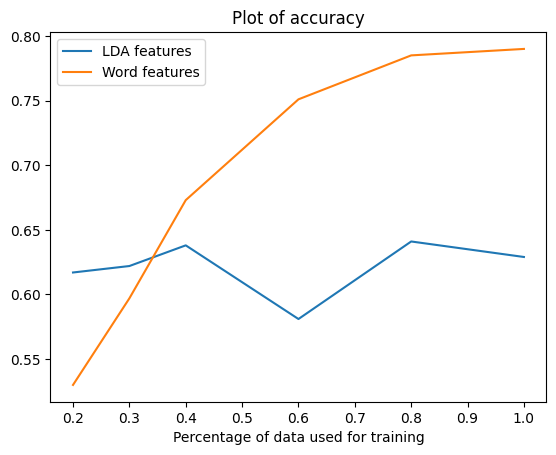

In [6]:
# Plotting
plt.plot(percentage_data, accs_LDA, label='LDA features')
plt.plot(percentage_data, accs_word, label='Word features')
plt.xlabel('Percentage of data used for training')
plt.title('Plot of accuracy')
plt.legend()
plt.savefig('../../output/exp3_plot1.jpg', format='jpeg')
plt.show()